# Development of Quarterly QA on Siemens Scanners

This will be performed on the Siemens 'long bottle' phantom in the most used head coil. This is the phantom used for the Siemens coil QA and it can be easily positioned using the dedicated Siemens foam pad.

We'll need to check that this phantom is available on all the scanners. If not then we may need to drop back to using the short bottle and its holder. We should be able to code round the variation - the short bottle has a slightly larger diameter so we can identify the phantom from this.

We'll acquire the following images:
 - SE, 2 acqusitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting voltages to zero
 - TSE, 1 acquisition, ghosting -> short term stability
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

Other possible acquisitions to consider:
 - SE, multiple flip angles
 - CPMG service shim sequence
 - Siemens flip angle mapper
 - SE-EPI diffn for eddy currents -> measure variability in circularity (as encoding directions change)
 
Measurements to be made:
 - SNR, over 50% and (say) 80% of phantom
 - Non-circularity of edge of phantom
 - NMEA uniformity measure using smoothing kernel eg `[[1,2,1,],[2,4,2],[1,2,1]]` - 'normalised absolute deviation'
 - Ghosting on SE/TSE/EPI

### Boiler plate

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report, ghosting_report, uniformity_report
from mriqa.tools import mean_im, diff_im, snr_im, snr
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

### Series Index
Details of series to analyse.

In [2]:
patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Signal_Combined': [27, 31],
    'Noise': [22, 24],
    'Noise_Combined': [23, 25],
    'Geometry': [28, 32]
}

### Uniformity
We can use the same routines for uniformity as for the oil sphere. As the phantom is cylindrical of course only the axial plane will be considered. In addition, at 3T there will be a significant contribution from the $B_1^+$ non-uniformity as well as the receive coil sensitivities. It's not clear how much of this will be taken out by the prescan normalize; the scan used to calibrate that may have different sensitivity to flip angle variations. On the other hand this is quite a small phantom so the $B_1^+$ effects may not be very pronounced over this volume.

float64 float64
float64 float64


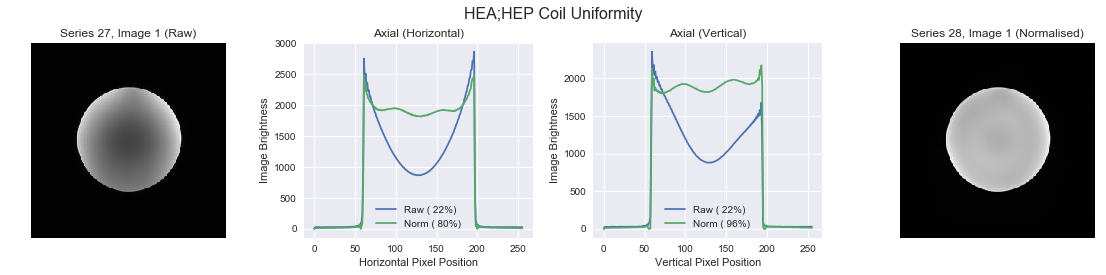

In [3]:
raw_tra = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
psn_tra = fetch_series(patid, studyid, sernos=series['Geometry'])
df = uniformity_report(raw_dobjs=raw_tra[:1], psn_dobjs=psn_tra[:1], phantom=SIEMENSLONGBOTTLE)

In [4]:
df.T

Axial
XProfileRaw        [0.0, 28.8571428571, 30.7142857143, 28.2857142...
XUniformityRaw                                               22.3022
YProfileRaw        [0.0, 28.2857142857, 28.0, 27.8571428571, 28.1...
YUniformityRaw                                               21.8978
XProfileNorm       [0.0, 11.5714285714, 12.2857142857, 11.5714285...
XUniformityNorm                                              79.7101
YProfileNorm       [0.0, 12.0, 13.0, 12.4285714286, 12.8571428571...
YUniformityNorm                                              95.6204
ACRUniformityRaw                                             76.5293
ACRUniformityNorm                                              96.43
SeriesRaw                                                         27
ProtocolRaw                                         QUARTERLY_QA_SNR
SequenceRaw                                                   *se2d1
OrientRaw                                                   Axial/RL
CoilRaw                                                      HEA;HEP
SeriesNorm                                                        28
ProtocolNorm                                        QUARTERLY_QA_SNR
SequenceNorm                                                  *se2d1
OrientNorm                                                  Axial/RL
CoilNorm                                                     HEA;HEP

## NEMA Uniformity

The MROI is 0.75 of phantom by area so $\frac{\sqrt{3}}{2}$ by linear extent.

So get a mask for the phantom and radius $R$. Generate mask of radius $\frac{\sqrt{3}}{2}\cdot R$

SROI is a small ROI of area of field of view - doesn't say whether square or round so $nx = NX \sqrt{0.0015}$, $ny = NY \sqrt{0.0015}$ - rectangular area. Must lie inside MROI. Not clear what other constraints.

Smoothing is allowed (but not mandated) with the kernel:
$$
W = \frac{1}{16} \cdot
\left( \begin{array}{ccc}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 \end{array} \right)
$$

It is far from clear why this kernel is preferred rather than a Gaussian.

### 2.3.2 Peak Deviation Non-Uniformity

For pixels within the MROI, the maximum (S max ) and minimum (S min ) values are determined.
A span ∆ and midrange value S are calculated as:
$$
\Delta = \frac{S_{\mbox{max}} - S_{\mbox{min}}}{2}
$$
$$
\overline{S} = \frac{S_{\mbox{max}} + S_{\mbox{min}}}{2}
$$
The ratio of $\Delta$ to $\bar{S}$ is multiplied by 100, and expressed as a percentage non-uniformity.
The Peak Deviation non-uniformity measure (N) is defined as:
$$
N = \frac{\Delta}{\overline{S}} = 100\frac{S_{\mbox{max}} - S_{\mbox{min}}}{S_{\mbox{max}} + S_{\mbox{min}}}
$$

The peak deviation non-uniformity measure is sensitive to image SNR. As SNR decreases,$S_{\mbox{max}}$ and $S_{\mbox{min}}$ diverge, lowering computed peak deviation uniformity.

----

We can do this straightforwardly for the interior of the phantom.

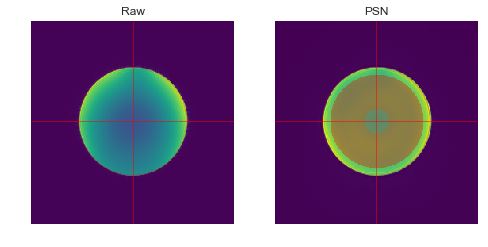

Pixel Dimensions: 0.977 x 0.977 mm
Phantom Centre: 128, 126 pixels; Phantom Radius: 68 pixels, 66.41 mm
NEMA Peak Deviation Non-Uniformity (Raw) 47.10%
NEMA Peak Deviation Non-Uniformity (PSN) 8.97%


In [5]:
raw_tra = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
psn_tra = fetch_series(patid, studyid, sernos=series['Geometry'])

raw_img = (raw_tra[0].pixel_array & 0xfff).astype(float)
psn_img = (psn_tra[0].pixel_array & 0xfff).astype(float)
pix_dims = np.asarray(raw_tra[0].PixelSpacing)
nrows, ncols = raw_img.shape

expected_radius = SIEMENSLONGBOTTLE['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(psn_img, expected_radius=expected_radius)

dists = np.sqrt((np.arange(nrows)[:, None] - centre_y) ** 2 + (np.arange(ncols)[None, :] - centre_x) ** 2)

# select a central region of 75% by area
nrows, ncols = psn_img.shape
radius75 = radius * np.sqrt(0.75)
mask75  = np.zeros_like(raw_img, dtype=bool)
mask75 = dists < radius75

psn_pixels = psn_img[mask75]
raw_pixels = raw_img[mask75]

N_raw = 0.5 * raw_pixels.ptp() / np.mean([raw_pixels.min(), raw_pixels.max()])
N_psn = 0.5 * psn_pixels.ptp() / np.mean([psn_pixels.min(), psn_pixels.max()])

radius05 = radius * np.sqrt(0.05)
mask05  = np.zeros_like(raw_img, dtype=bool)
mask05 = dists < radius05

psn_pixels = psn_img[mask05]
raw_pixels = raw_img[mask05]

fig, axs = plt.subplots(1, 2)

axs[0].imshow(raw_img, cmap='viridis', interpolation='nearest')
axs[0].axis('off')
axs[0].grid(False)

axs[0].axvline(centre_x, linewidth=0.5, color='red')
axs[0].axhline(centre_y, linewidth=0.5, color='red')

circle  = plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
axs[0].add_artist(circle)
axs[0].set_title('Raw')

axs[1].imshow(psn_img, cmap='viridis', interpolation='nearest')
axs[1].axis('off')
axs[1].grid(False)

axs[1].axvline(centre_x, linewidth=0.5, color='red')
axs[1].axhline(centre_y, linewidth=0.5, color='red')

circle  = plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
axs[1].add_artist(circle)
axs[1].set_title('PSN')
axs[1].imshow(np.ma.masked_where(~mask75, mask75), alpha=0.35, cmap=mpl.colors.ListedColormap(['r', 'g']))
axs[1].imshow(np.ma.masked_where(~mask05, mask05), alpha=0.25, cmap=mpl.colors.ListedColormap(['c', 'm']))

plt.show()

print('Pixel Dimensions: %0.3f x %0.3f mm' % tuple(pix_dims))
print('Phantom Centre: %d, %d pixels; Phantom Radius: %d pixels, %0.2f mm' % (centre_x, centre_y, radius, radius*pix_dims[0]))
print('NEMA Peak Deviation Non-Uniformity (Raw) %0.2f%%' % (100*N_raw))
print('NEMA Peak Deviation Non-Uniformity (PSN) %0.2f%%' % (100*N_psn))

### 2.3.3 Gray-Scale Uniformity Map
It shall be permitted to provide a gray-scale coded map of the image showing where, and by how much,
departures in uniformity occur. Such a map is readily created by the following procedure:
1. Select a region of interest (ROI) on the center of the image that encloses a sufficient number of pixels
to yield the desired statistical precision (e.g., 400 pixels to provide 5% precision), and determine its
mean value. If the ROI is in a region with anomalous signal characteristics (e.g. center of high signal
intensity caused by dielectric resonance) use the mean from the MROI.
2. Examine the signal from each pixel in the entire image and assign a gray level to each pixel
according to the magnitude by which the signal differs from the mean value at the center ROI. Pixels with
signal magnitudes differing by less than 10% from the mean value shall be assigned a neutral gray
level. Pixels whose signals are more than 10% greater than the mean value, but less than 20% greater, shall be assigned the next lighter gray level. Pixels whose signals are more than 10% smaller than the mean value but less than 20% smaller, shall be assigned the next darker gray level. Pixels with signals more than 20% greater than the mean value shall be white, and pixels with signals more than 20% smaller than the mean value shall be black.
3. The indicated procedure produces a five gray-level representation of the image non-uniformity with
the following ranges relative to the mean value:
  a. lowest signal value to -20%
  b. -20% through -10%
  c. -10% through +10%
  d. +10% through +20%
  e. +20% through to highest signal value

These five unequally sized bands visualize the location and structure of non-uniformities without showing
the complex structure immediately surrounding the coil elements.
4. Display the gray-scale coded image on the monitor to readily visualize the amount, the magnitude,
and the location of non-uniformities in the image. Since non-uniformity location in the image is correlated
with the cause of the non-uniformity, the coded image is performance-diagnostic tool for system
adjustment. Supply a copy of this coded image with the measurement report.
5. Alternatively, the gray-level representation of image non-uniformity may also be shown using the
method of MS-6. A single gray level shall be assigned to all pixels in the signal producing area of the
image having intensity values (I) such that:

$$
S \times (1-F) \lt I \le S \times (1+F)
$$
Where:
> 
 * $S$ is the mean pixel value within the MROI (as defined in Section 2.2.2) minus any baseline pixel offset value.
 * $F$ is a fraction with a fixed value of 0.1 that specifies the width of a histogram bin.
 * $I$ is the intensity value that have has been corrected for baseline pixel offset, if any.

Pixels in the signal producing area of the image having intensities:
$$
S \times (1+F) \lt I \le S \times (1+ 2 \times F)
$$

are assigned the next brighter gray level.

This process is continued, with each gray level including pixels for which I is:
$$
S \times (1 + n \times F) \lt I \le S \times (1 + (n+1) \times F), n = 1,2,3...
$$

until all pixels brighter than S have been assigned a gray level. Pixels in the highest intensity bin are
assigned to white.
A similar procedure is applied to pixels with intensities less than $S \times (1 – F)$ . $S \times (1 – F)$. The gray level bins in this case are defined by:

$$
S \times (1 - (n+1) \times F) \lt I \le S \times (1 - n \times F), n = 1,2,3...
$$
until all pixels darker than $S$ have been assigned a gray level. Pixels in the lowest intensity bin are
assigned to black. The resulting images shall be labeled to indicate physical dimensions.

-----

These seem to be just two alternate methods based on setting just two or three grey levels either side of the average. We should be able to do this all by subtracting off average, defining the color map and setting the colormap boundaries at +/-10% and +/- 20% etc of mean value.

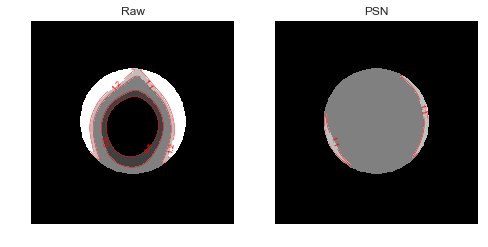

In [6]:
from scipy.ndimage import gaussian_filter
from numpy.ma import masked_where

def plot_nema_uniformity(image, mroi, levels=None, ax=None, title='Uniformity', image_centre=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)

    image_smoothed = gaussian_filter(image, sigma=1.5)
    image_smoothed = masked_where(~mroi, image_smoothed)
    image_smoothed /= image_smoothed.mean()

    if levels is None:
        lower_lim = image_smoothed.min() if image_smoothed.min() < 0.8 else 0.7
        upper_lim = image_smoothed.max() if image_smoothed.max() > 1.2 else 1.3
        levels = [lower_lim, 0.8, 0.9, 1.1, 1.2, upper_lim]
    colours = ['%s' % grey for grey in np.linspace(0.0, 1.0, len(levels)-1)]

    # just to give a dark background
    background = np.zeros_like(image)
    nrows, ncols = background.shape
    background[nrows//2, ncols//2] = 1
    ax.imshow(background, cmap='gray', interpolation='nearest')
    ax.axis('off')

    # filled contour plot
    ax.contourf(image_smoothed, levels=levels, colors=colours)
    cntr = ax.contour(image_smoothed, levels=levels, colors='r', linewidths=0.5)
    ax.clabel(cntr, inline=True, fontsize=8, fmt='%0.1f')

    if image_centre is not None:
        centre_x, centre_y = image_centre
        ax.axvline(centre_x, linewidth=0.5, color='red')
        ax.axhline(centre_y, linewidth=0.5, color='red')

    ax.set_title(title)

# will need to wrap this up as well
nrows, ncols = psn_img.shape
radius95 = radius * np.sqrt(0.95)
mask95 = dists < radius95

fig, axs = plt.subplots(1, 2)
plot_nema_uniformity(raw_img, mroi=mask95, ax=axs[0], title='Raw')
plot_nema_uniformity(psn_img, mroi=mask95, ax=axs[1], title='PSN')

This seems a pretty rubbish visualisation of the uniformity.

### 2.3.5 Normalized Absolute Average Deviation Uniformity

In order to reduce the influence of image SNR on the analysis of image uniformity all pixels within the
MROI will be used to compute image uniformity.

1. Compute the average pixel intensity within the MROI.
2. Compute the absolute deviation or difference of each pixel within the MROI from the average of the
   MROI. This statistical measure is called the Absolute Average Deviation (AAD) and is a measure of
   spread, or variability, within a data set.
3. To normalize the AAD, divide by the average signal within the MROI.
4. NAAD is computed as:

$$
NAAD = 100 \left( 1 - \frac{1}{N\bar{Y}} \sum_{i=1}^{N} | Y_i - \bar{Y} | \right)
$$

   Where $Y_i$ is the individual pixel value in the MROI, $\bar{Y}$ is the mean of all pixels in the MROI,
   $|Y_i – \bar{Y}|$ is the absolute deviation for pixel $i$ and $N$ is the total number of pixels in the MROI.

-----------------

In other words use the MAD normalised to the mean.

In [7]:
def naad(image):
    """Normalized Absolute Average Deviation
    """
    mad = abs(image - image.mean()).mean()
    return mad / image.mean()

    
def acr_naad_uniformity(image, mask):
    """Image uniformity using ACR Normalized Absolute Average Deviation
    """
    image_smoothed = gaussian_filter(image, sigma=1.5)
    image_smoothed = masked_where(~mask, image_smoothed)
    image_smoothed /= image_smoothed.mean()

    return 100 * (1 - naad(image_smoothed))


print('NAAD Uniformity = %0.1f%%' % acr_naad_uniformity(raw_img, mask95))

NAAD Uniformity = 76.4%


### 2.3.4 ACR MR Accreditation Program (ACR-MRAP) Uniformity
In order to reduce the influence of image SNR on the analysis of image uniformity $S_{\mathrm{max}}$ and $S_{\mathrm{min}}$ can be
measured over a small subregion of interest (SROI), wholly enclosed within the MROI, that covers
approximately 0.15% of the number of image pixels (e.g. ~100 pixels for a 256x256 matrix image). For
pixels within the MROI, the maximum ($S_{\mathrm{max}}$) and minimum ($S_{\mathrm{min}}$) values are determined as follows:
1. set the window width to a narrow band and adjust the window level so that a small region of the highest
signal intensity within the MROI is isolated. Position the SROI in the high intensity region and the average
within that SROI is $S_{\mathrm{max}}$.
2. set the window width to a narrow band and readjust the window level so that a small region of the
lowest signal intensity within the MROI is isolated. Position the SROI in the low intensity region and the
average within that SROI is $S_{\mathrm{min}}$.
Compute image non-uniformity using the same method as 2.3.2 Peak Deviation Non-uniformity:
$$
PIU = 100 \left(1 - \frac{S_{\mathrm{max}} - S_{\mathrm{min}}}{S_{\mathrm{max}} + S_{\mathrm{min}}} \right)
$$

Enter this value in the column labeled *Percent Image Uniformity* of the MRI Equipment Performance
Evaluation Data Form (Appendix A), for that coil.

----------------

This is an average of a 100 pixel region round the brightest part of image and a similar region around the darkest.
Use these for $S_\mathrm{min}$ and  $S_\mathrm{max}$. Isn't this equivalent to finding the location of the maximum in a gaussan smoothed image and then taking an average over a disc centred there (or why not just use the maximum in the filtered image??!). We need to be careful with edge effects. The Gaussian blurring will go wrong at the edges of the phantom. Is there any other way? Median filters? How do these behave at the edges?

OK, we can Gaussian smooth without the mask, then mask as we'll need to find the minimum *within* the phantom. Then
we need a way of finding the closest K unmasked pixels to the two locations.

Could list coordinates of all unmasked pixels. Then sort on distance from location and take the first K values.

This is a pretty messy description. To follow it exactly we could use windowing and connected components to find *significant* regions enclosing the minimum and maximum. We'd still need criteria for the windows and what is a large enough compoent to be significant.

Could we maybe generate a mask of the brightest N pixels in the image (where N is 200-300 say). Select the largest connected component. Find the maximum pixel in the component. Find the 100 closest pixels to this. Take their mean.  

Maybe percentiles better - threshold [95, 100] ( of[0, 5] ) of pixels (in mask). Connected components. Use (the complement of) the component as the array mask => 2D argmax. Sort coords by distance from max. Take first 100.



Get low and high brighness regions based on perceptile thresholds.

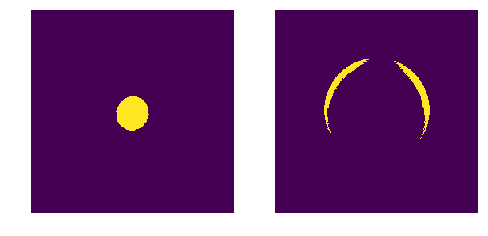

In [8]:
image_masked = masked_where(~mask95, raw_img)

pc_low = np.nanpercentile(image_masked.filled(np.nan), 10)
pc_high = np.nanpercentile(image_masked.filled(np.nan), 90)
dark_parts_mask = image_masked.filled(pc_low) < pc_low
bright_parts_mask = image_masked.filled(pc_high) > pc_high

fig, axs = plt.subplots(1, 2)
for ax, image, in zip(axs, [dark_parts_mask, bright_parts_mask]):
    ax.imshow(image, cmap='viridis')
    ax.grid(False)
    ax.axis('off')

Label connected components.

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


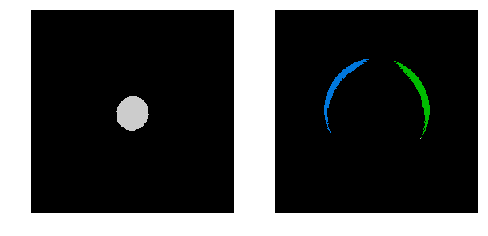

In [9]:
from skimage import measure
dark_labels = measure.label(dark_parts_mask, background=0)
bright_labels = measure.label(bright_parts_mask, background=0)

fig, axs = plt.subplots(1, 2)
for ax, image, in zip(axs, [dark_labels, bright_labels]):
    ax.imshow(image, cmap='spectral')
    ax.grid(False)
    ax.axis('off')


Check the components look right

{0, 1}
{0, 1, 2, 3, 4}


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


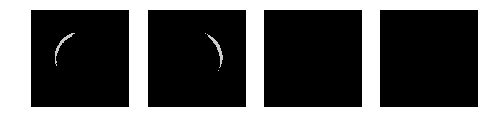

In [10]:
print(set(dark_labels.flat))
print(set(bright_labels.flat))
nlabels = bright_labels.max()
fig, axs = plt.subplots(1, nlabels)
for i, ax in enumerate(axs, start=1):
    ax.imshow(bright_labels == i, cmap='spectral')
    ax.grid(False)
    ax.axis('off')

Pick the largest component and find the location of the minimum (maximum) on the asumption that the first labelled component is the largest.

In [11]:
dark_mask_image = masked_where(dark_labels != 1, raw_img)
bright_mask_image = masked_where(bright_labels != 1, raw_img)

darkest_locn = np.unravel_index(np.argmin(dark_mask_image), dark_mask_image.shape)
brightest_locn = np.unravel_index(np.argmax(bright_mask_image), dark_mask_image.shape)

print('Darkest Locn: %s, Brightest Locn: %s' % (darkest_locn, brightest_locn))

Darkest Locn: (128, 129), Brightest Locn: (80, 81)


Construct regions around the brightest and darkest points.

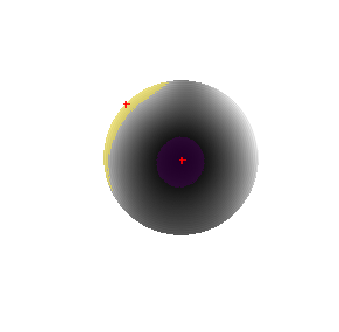

In [12]:
from scipy import sparse

def region_around_extreme(mask_image, extreme_location):
    Y, X = np.nonzero(mask_image >= 0)
    y0, x0 = extreme_location
    ordering = np.argsort(np.hypot(Y - y0, X - x0))
    Ys, Xs = Y[ordering], X[ordering]
    # there may be a simpler way to build the mask from the coords but this works
    return sparse.coo_matrix(
        (np.ones(len(Ys)), (Ys, Xs)),
        shape=dark_mask_image.shape,
        dtype=bool
    ).toarray()
    
dark_region = region_around_extreme(dark_mask_image, darkest_locn)
bright_region = region_around_extreme(bright_mask_image, brightest_locn)

plt.imshow(image_masked, cmap='gray')
plt.grid(False)
plt.axis('off')

regions = dark_region + 2 * bright_region
regions_masked = masked_where(regions < 1, regions)
plt.imshow(regions_masked, alpha=0.5, cmap='viridis')

plt.scatter([darkest_locn[1], brightest_locn[1]], [darkest_locn[0], brightest_locn[0]], marker='+', color='r');


Statistics

In [13]:
s_min = masked_where(~dark_region, raw_img).mean()
s_max = masked_where(~bright_region, raw_img).mean()
piu = 100 * (s_max - s_min) / (s_max + s_min)

print('S_min = %0.0f, S_max = %0.0f, PIU = %0.1f%%' % (s_min, s_max, piu))

S_min = 947, S_max = 2460, PIU = 44.4%
